In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Importando os dados

In [2]:
# reading white wine csv
df = pd.read_csv('./winequality-white.csv', sep=';') # escolhi o vinho branco por conta que tem mais amostras
print(f'Número de amostras: {df.shape[0]}')
df.head()

Número de amostras: 4898


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
n_samples = df.shape[0]
print(f'Número de linhas com dados faltantes: {n_samples - df.dropna().shape[0]}') # :)

Número de linhas com dados faltantes: 0


## Análises iniciais

In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


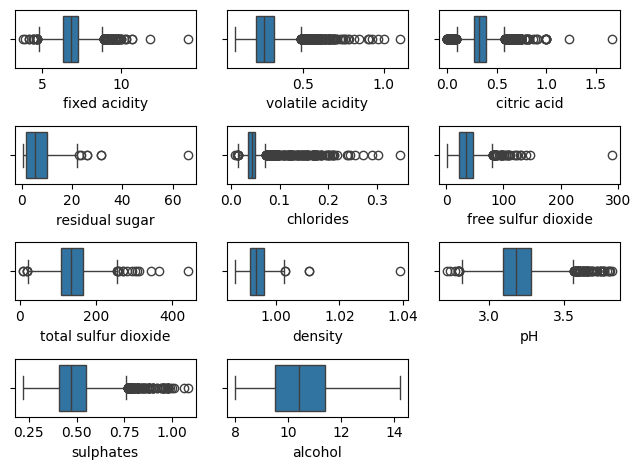

In [5]:
# detectando outliers
fig, axes = plt.subplots(4,3)

for col in range(df.shape[1]-1):
    # gerando boxplot
    sns.boxplot(data=df.iloc[:,col], orient='h', ax=axes.flatten()[col])

fig.delaxes(axes[3,2]) # deleta o boxplot do canto inferior direito
plt.tight_layout()
plt.show()

quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
dtype: int64

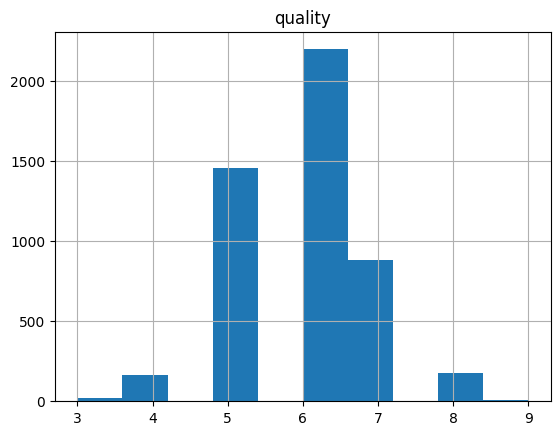

In [6]:
# número de amostras por classe
df.hist(column='quality', bins=10)
df.groupby('quality').size()

<Axes: >

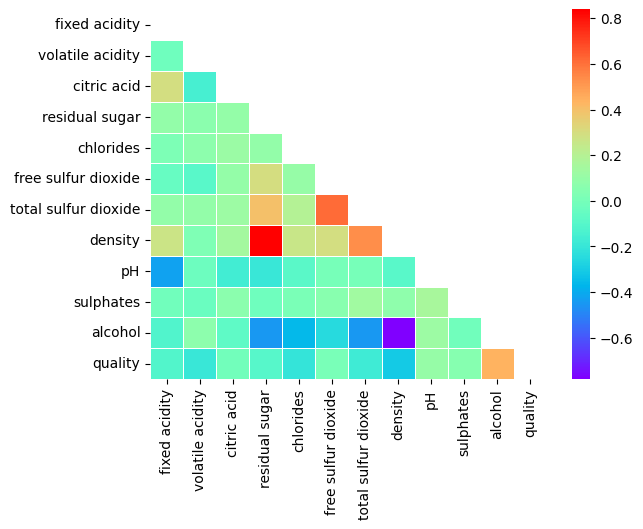

In [7]:
# calculando a correlação
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) # para deixar somente o triângulo abaixo da identidade
sns.heatmap(corr, mask=mask, linewidth=.5, cmap='rainbow')

Podemos ver que os dados são desbalanceados

Resolvi não lidar com a questão de outliers justamente por como os dados estão desbalanceados

Cheguei a cogitar a questão de normalizar, mas com base nas respostas de [is-standardization-needed-before-fitting-logistic-regression](https://stats.stackexchange.com/questions/48360/is-standardization-needed-before-fitting-logistic-regression) e [logistic-regression-python-solvers-definitions](https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions/52388406#52388406), decidi que não seria necessário

# Treinando o modelo

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier

In [9]:
# dividindo em treino e teste
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# usar stratify por conta de dataset desbalanceado
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [10]:
# abordagem multinomial
clf = LogisticRegression(solver='newton-cg', max_iter=3000).fit(X_train, y_train) # solver='newton-cg' suporte para classificação multiclass

In [11]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division = 0)) # hmmmm isso aqui tá ruim dms

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        33
           5       0.53      0.49      0.51       291
           6       0.51      0.74      0.60       440
           7       0.59      0.24      0.34       176
           8       0.00      0.00      0.00        35
           9       0.00      0.00      0.00         1

    accuracy                           0.52       980
   macro avg       0.23      0.21      0.21       980
weighted avg       0.49      0.52      0.48       980



In [12]:
# abordagem de um classificador para cada classe
clf = OneVsRestClassifier(LogisticRegression(solver='newton-cg', max_iter=3000)).fit(X_train, y_train)

In [13]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division = 0)) # isso aqui também tá ruim dms

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        33
           5       0.53      0.48      0.51       291
           6       0.49      0.77      0.60       440
           7       0.65      0.10      0.17       176
           8       0.00      0.00      0.00        35
           9       0.00      0.00      0.00         1

    accuracy                           0.51       980
   macro avg       0.24      0.19      0.18       980
weighted avg       0.50      0.51      0.45       980



## Comentários

Essa semana foi um tequinho corrida, então acho que deixei de fazer algumas coisas.
O modelo foi bem ruim especialmente nas classes com menos amostras, cheguei a ver algumas implementações, mas no caso as pessoas transformavam o problema multiclass em um problema de classificação binária, fazendo um limiar da qualidade entre bom e ruim. Acho que fazendo isso de fato melhoraria a performance, mas aí também estaria modificando a estrutura do problema, então resolvi não fazer